# 1. Imports and Configuration

In [8]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt

# Configuration
# ECG Directory
DATA_DIR = r"C:\Users\anton\Downloads\Test"

# TFRecord file
TFRECORD_FILE = "ecg.tfrecord"

# Parameters
BATCH_SIZE = 32
input_shape = (5000, 12)
latent_dim = 64

# 2. CSV to TFRecord

In [9]:
def serialize_example(ecg_data):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Convert the array to bytes
    ecg_bytes = tf.io.serialize_tensor(ecg_data).numpy()

    # Create a dictionary mapping the feature name to the tf.Example-compatible data type
    feature = {
        'ecg': tf.train.Feature(bytes_list=tf.train.BytesList(value=[ecg_bytes])),
    }

    # Create a Features message using tf.train.Example
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def convert_csvs_to_tfrecord(file_pattern, output_filename):
    """
    Reads CSVs, normalizes them, and saves to TFRecord.
    """
    csv_files = glob.glob(file_pattern)
    print(f"Found {len(csv_files)} CSV files. Converting to TFRecord...")

    with tf.io.TFRecordWriter(output_filename) as writer:
        for file in csv_files:
            try:
                # 1. Read CSV (assuming no header based on your file)
                df = pd.read_csv(file, header=None)
                data = df.values.astype(np.float32)

                # Check shape
                if data.shape != (5000, 12):
                    print(f"Skipping {file}: Invalid shape {data.shape}")
                    continue

                # 2. Normalize (Z-score normalization per record)
                # This ensures the signal centers around 0 with std dev 1
                mean = np.mean(data)
                std = np.std(data)
                if std > 0:
                    data = (data - mean) / std

                # 3. Serialize and Write
                example = serialize_example(data)
                writer.write(example)

            except Exception as e:
                print(f"Error processing {file}: {e}")

    print(f"Done! Saved to {output_filename}")

# --- RUN THE CONVERSION ---
# Assumes files are in DATA_DIR and end in .csv
convert_csvs_to_tfrecord(os.path.join(DATA_DIR, "*.csv"), TFRECORD_FILE)

Found 490 CSV files. Converting to TFRecord...
Done! Saved to ecg.tfrecord


# 3. Data Pipeline

In [10]:
def parse_tfrecord_fn(example):
    """
    Parses a single tf.Example message from the TFRecord.
    """
    feature_description = {
        'ecg': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)

    # Parse the tensor back to float32
    ecg = tf.io.parse_tensor(example['ecg'], out_type=tf.float32)
    ecg = tf.reshape(ecg, [5000, 12])

    # Autoencoders need (Input, Target). For us, Target == Input.
    return ecg, ecg

def get_dataset(tfrecord_path, batch_size=32):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Initialize the dataset
train_dataset = get_dataset(TFRECORD_FILE, BATCH_SIZE)

# 4. Model and Traning

In [11]:
def build_autoencoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # --- ENCODER ---
    # Compress 5000 -> 2500
    x = layers.Conv1D(32, 5, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # Compress 2500 -> 1250
    x = layers.Conv1D(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Compress 1250 -> 625
    x = layers.Conv1D(128, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Flatten and compress to latent vector
    shape_before_flatten = x.shape[1:]  # (625, 128)
    x = layers.Flatten()(x)

    latent = layers.Dense(latent_dim, name='latent_space')(x)

    # --- DECODER ---
    # FIX: Explicitly convert numpy int to Python int
    # Keras layers require standard Python integers for the 'units' argument
    units = int(np.prod(shape_before_flatten))

    x = layers.Dense(units)(latent)
    x = layers.Reshape(shape_before_flatten)(x)
    x = layers.ReLU()(x)

    # Upsample 625 -> 1250
    x = layers.Conv1DTranspose(128, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Upsample 1250 -> 2500
    x = layers.Conv1DTranspose(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Upsample 2500 -> 5000
    x = layers.Conv1DTranspose(32, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Final output layer
    outputs = layers.Conv1D(12, 1, padding='same', activation='linear')(x)

    return models.Model(inputs, outputs)

# Build, Compile, and Train
autoencoder = build_autoencoder(input_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(train_dataset, epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - loss: 1.4828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 1.0265
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - loss: 0.9961
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.9868
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.9767
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - loss: 0.9509
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - loss: 0.8838
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - loss: 0.7749
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 0.6703
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 0.5868


# 5. Reconstruction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


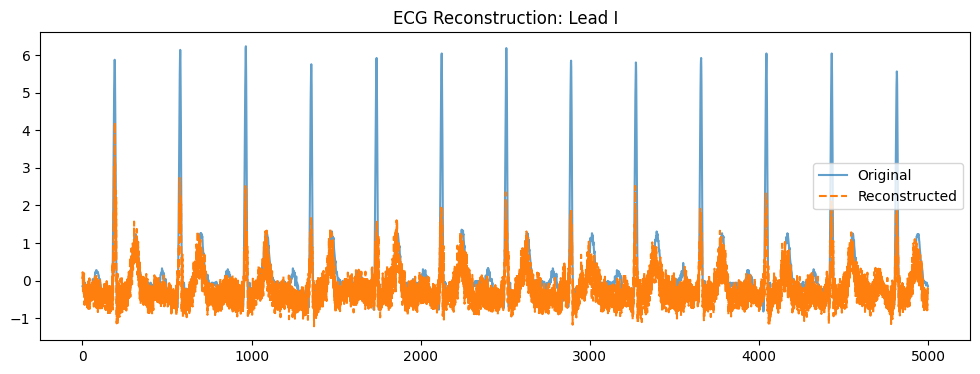

In [12]:
# Get a batch of data
for original_batch, _ in train_dataset.take(1):
    reconstructed_batch = autoencoder.predict(original_batch)

    # Plot Lead I (Index 0) for the first ECG in the batch
    plt.figure(figsize=(12, 4))

    # Original (Blue)
    plt.plot(original_batch[0, :, 0], label='Original', alpha=0.7)

    # Reconstructed (Orange)
    plt.plot(reconstructed_batch[0, :, 0], label='Reconstructed', linestyle='--')

    plt.title("ECG Reconstruction: Lead I")
    plt.legend()
    plt.show()
    break